In [32]:
import numpy as np
import pandas as pd
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

print("sklearn:", sklearn.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


from sklearn.metrics import accuracy_score, f1_score, make_scorer

sklearn: 1.6.1
numpy: 2.1.3
pandas: 2.2.3


In [2]:
df=pd.read_csv(r"D:\new downloads\all_month-cleaned.csv")

In [3]:
features = [
    "latitude",
    "longitude",
    "depth",
    "dmin",
    "rms",
    "horizontalError",
    "depthError"
]

target = "mag"

df = df[features + [target]]
df.isna().sum()


latitude              0
longitude             0
depth                 0
dmin               1355
rms                   2
horizontalError    1910
depthError           97
mag                   1
dtype: int64

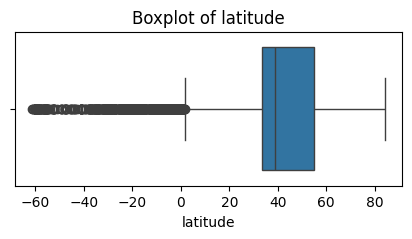

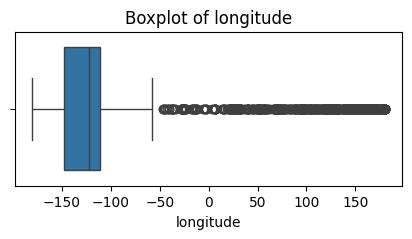

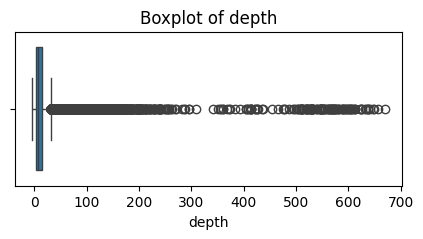

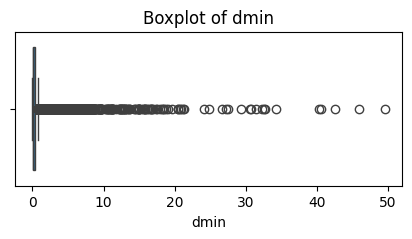

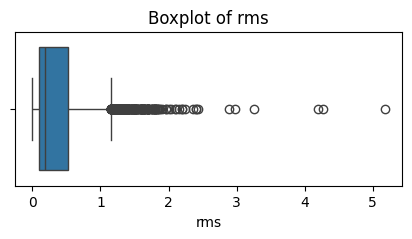

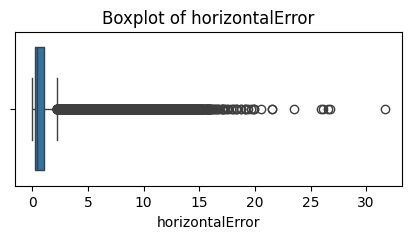

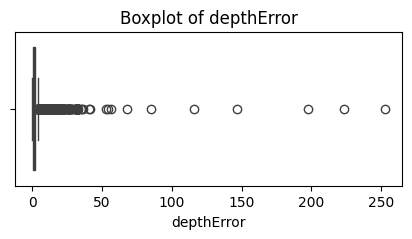

In [4]:
num_cols = df.drop(columns=['mag']).select_dtypes(include=['int64','float64']).columns
num_cols
for col in num_cols:
    plt.figure(figsize=(5,2))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

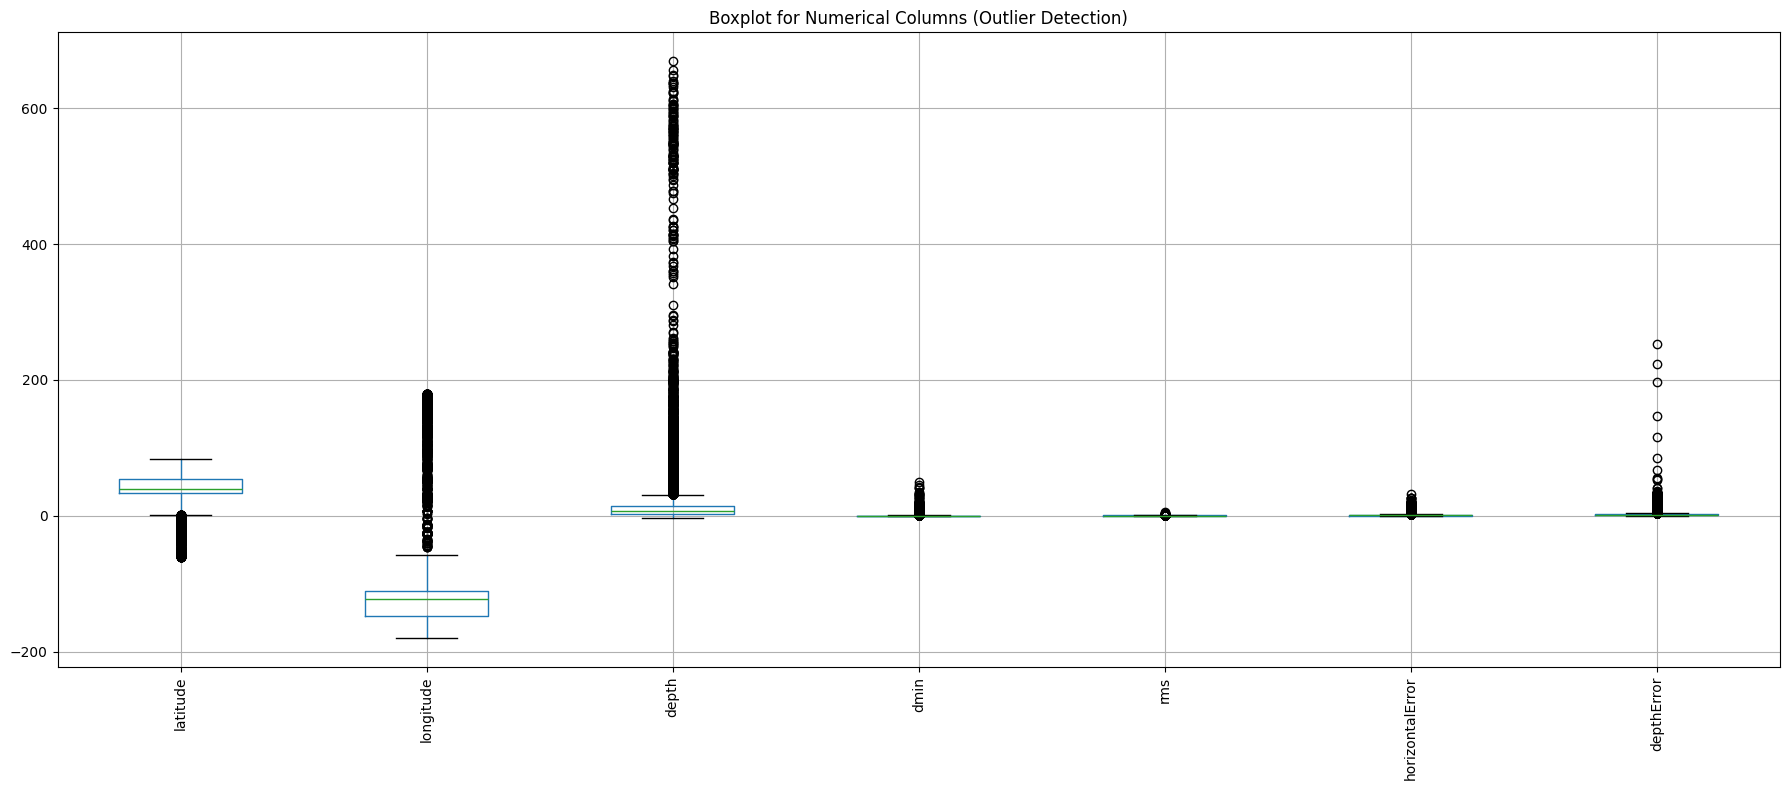

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,8))
df[num_cols].boxplot(rot=90)
plt.title("Boxplot for Numerical Columns (Outlier Detection)")
plt.tight_layout()
plt.show()

In [6]:
outlier_summary = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_summary[col] = outliers.shape[0]

outlier_summary

{'latitude': 799,
 'longitude': 1580,
 'depth': 2731,
 'dmin': 2090,
 'rms': 430,
 'horizontalError': 2771,
 'depthError': 2322}

In [7]:
df.isna().sum()/len(df)*100

latitude            0.000000
longitude           0.000000
depth               0.000000
dmin                7.828297
rms                 0.011555
horizontalError    11.034722
depthError          0.560402
mag                 0.005777
dtype: float64

In [8]:
df = df.drop(columns=['magError'])


KeyError: "['magError'] not found in axis"

In [9]:
df['horizontalError'] = df['horizontalError'].fillna(
    df['horizontalError'].median()
)

In [10]:
df['dmin'] = df['dmin'].fillna(
    df['dmin'].median()
)

In [11]:
# ensure mag is numeric
df['mag'] = pd.to_numeric(df['mag'], errors='coerce')

# fill missing value with median
df['mag'] = df['mag'].fillna(df['mag'].median())

In [12]:
# FIX depthError (numeric + median)
df['depthError'] = pd.to_numeric(df['depthError'], errors='coerce')
df['depthError'] = df['depthError'].fillna(df['depthError'].median())

In [13]:
# Ensure numeric
df['rms'] = pd.to_numeric(df['rms'], errors='coerce')

# Fill missing value with median
df['rms'] = df['rms'].fillna(df['rms'].median())

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17309 entries, 0 to 17308
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   latitude         17309 non-null  float64
 1   longitude        17309 non-null  float64
 2   depth            17309 non-null  float64
 3   dmin             17309 non-null  float64
 4   rms              17309 non-null  float64
 5   horizontalError  17309 non-null  float64
 6   depthError       17309 non-null  float64
 7   mag              17309 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


In [15]:
df.duplicated().sum()


np.int64(2)

In [16]:
df = df.drop_duplicates()


In [17]:
df.duplicated().sum()


np.int64(0)

In [18]:
df.describe()


,latitude,longitude,depth,dmin,rms,horizontalError,depthError,mag
count,17307.000000,17307.000000,17307.000000,17307.000000,17307.000000,17307.000000,17307.000000,17307.000000
mean,39.623567,-104.476192,21.983603,0.504999,0.324155,1.631626,2.460540,1.750283
std,18.911007,76.195530,55.838669,1.785243,0.338441,3.156572,5.744441,1.336407
min,-61.160400,-179.987200,-3.500000,0.000000,0.000000,0.000000,0.000000,-1.420000
25%,33.498833,-147.952707,3.010000,0.020530,0.100000,0.240000,0.500000,0.853300
50%,38.804832,-122.192333,7.410000,0.067235,0.180000,0.390000,0.864218,1.500000
75%,54.743500,-110.686167,14.320000,0.222490,0.520238,0.840000,1.985000,2.200000
max,84.105500,179.999400,669.556000,49.594000,5.178955,31.670000,252.700000,7.600000


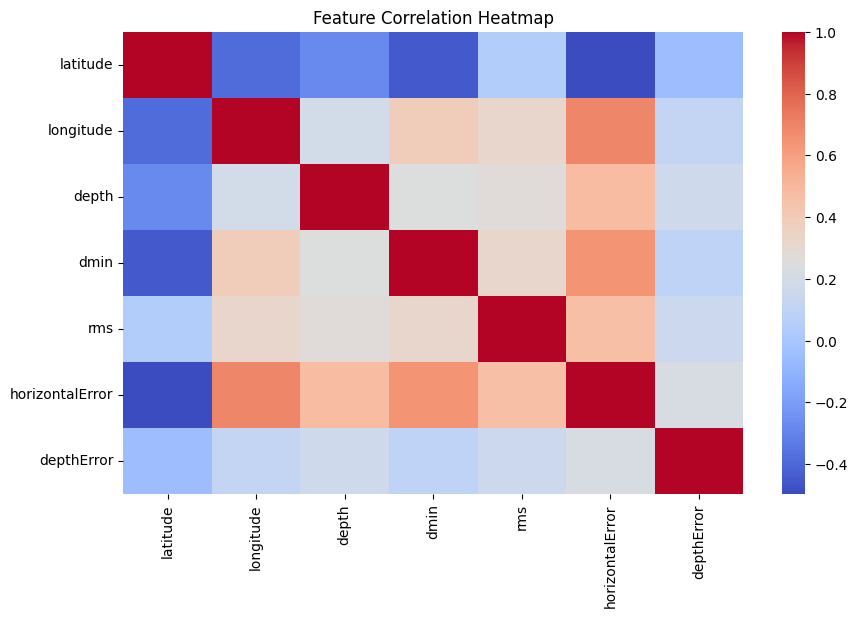

In [19]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.heatmap(df.drop('mag', axis=1).corr(), cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

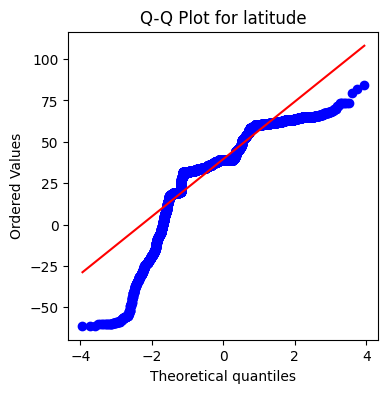

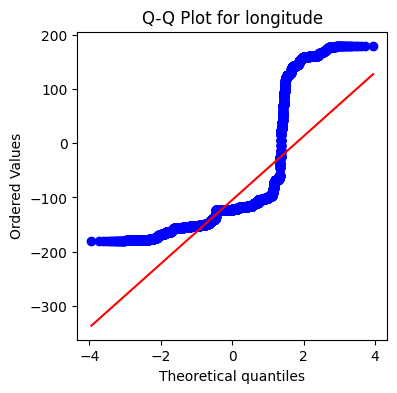

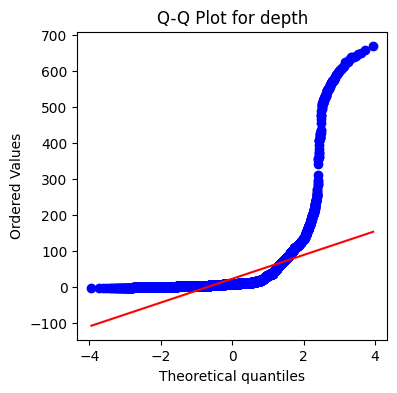

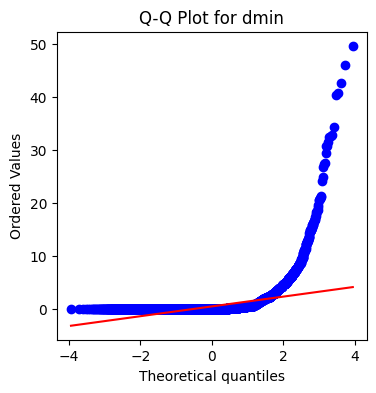

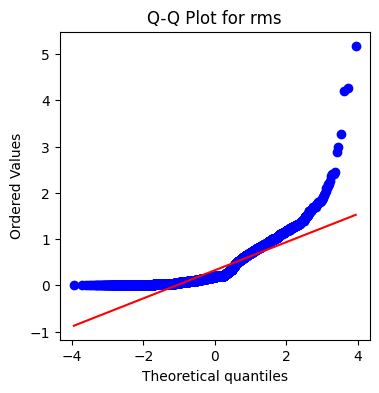

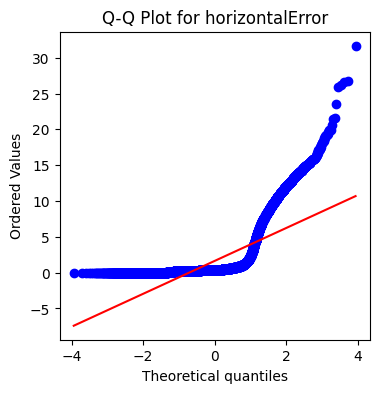

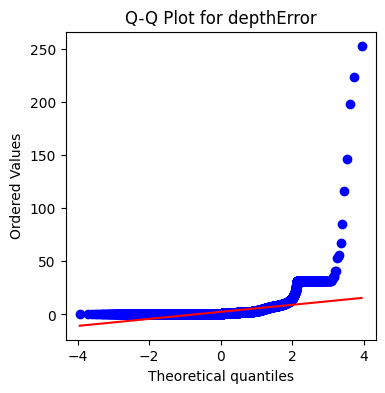

In [20]:
import matplotlib.pyplot as plt
import scipy.stats as stats

num_cols = df.drop('mag', axis=1).columns

for col in num_cols:
    plt.figure(figsize=(4, 4))
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {col}")
    plt.show()

In [21]:
x = df[features]
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)


In [22]:
print("Train shape:", x_train.shape)
print("Test shape:", x_test.shape)

print("\nTrain class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nTest class distribution:")
print(pd.Series(y_test).value_counts(normalize=True))

Train shape: (13845, 7)
Test shape: (3462, 7)

Train class distribution:
mag
1.600000    0.019357
1.500000    0.019068
4.400000    0.017190
1.800000    0.016974
1.700000    0.016396
              ...   
2.190120    0.000072
1.919947    0.000072
2.465244    0.000072
1.654862    0.000072
1.595985    0.000072
Name: proportion, Length: 1476, dtype: float64

Test class distribution:
mag
 1.500000    0.021086
 1.600000    0.020220
 4.400000    0.017042
 4.500000    0.015309
 1.800000    0.015309
               ...   
-1.030000    0.000289
-0.470000    0.000289
 2.110524    0.000289
 1.913472    0.000289
-0.590000    0.000289
Name: proportion, Length: 652, dtype: float64


In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

features = [
    "latitude",
    "longitude",
    "depth",
    "dmin",
    "rms",
    "horizontalError",
    "depthError"
]

transformer = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), features)
    ],
    remainder="drop"
)

# CRITICAL (prevents warnings & mismatch)
transformer.set_output(transform="pandas")


ColumnTransformer(transformers=[('num', RobustScaler(),
                                 ['latitude', 'longitude', 'depth', 'dmin',
                                  'rms', 'horizontalError', 'depthError'])])

In [33]:
features = [
    "latitude",
    "longitude",
    "depth",
    "dmin",
    "rms",
    "horizontalError",
    "depthError"
]

target = "mag"

df = df[features + [target]].dropna()

X = df[features]
y = df[target]

# =========================
# 4. Train Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# =========================
# 5. Preprocessing
# =========================
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, features)
])

# =========================
# 6. Pipeline (REGRESSION)
# =========================
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", DecisionTreeRegressor(random_state=42))
])

# =========================
# 7. Hyperparameter Grid
# =========================
param_grid = {
    "model__max_depth": range(2, 30),
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 5]
}

# =========================
# 8. GridSearchCV
# =========================
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

grid.fit(X_train, y_train)

# =========================
# 9. Best Model
# =========================
best_model = grid.best_estimator_

print("Best Parameters:")
print(grid.best_params_)

print("\nBest CV MAE:")
print(-grid.best_score_)

# =========================
# 10. Evaluation
# =========================
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print("\nTRAIN METRICS")
print("MAE :", mean_absolute_error(y_train, y_train_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))
print("R2  :", r2_score(y_train, y_train_pred))

print("\nTEST METRICS")
print("MAE :", mean_absolute_error(y_test, y_test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("R2  :", r2_score(y_test, y_test_pred))


Best Parameters:
{'model__max_depth': 14, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2}

Best CV MAE:
0.34939483797820114

TRAIN METRICS
MAE : 0.2555623152912612
RMSE: 0.35240333616181757
R2  : 0.9297020391128488

TEST METRICS
MAE : 0.3530436768157344
RMSE: 0.4875962742774514
R2  : 0.8723761967679999


In [34]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print("\nTRAIN METRICS")
print("R2 :", r2_score(y_train, y_train_pred))
print("MAE:", mean_absolute_error(y_train, y_train_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_train_pred)))

print("\nTEST METRICS")
print("R2 :", r2_score(y_test, y_test_pred))
print("MAE:", mean_absolute_error(y_test, y_test_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred)))



TRAIN METRICS
R2 : 0.9297020391128488
MAE: 0.2555623152912612
RMSE: 0.35240333616181757

TEST METRICS
R2 : 0.8723761967679999
MAE: 0.3530436768157344
RMSE: 0.4875962742774514


In [35]:
import pickle

In [36]:
import pickle

with open("eq_dt_pipeline_2.pkl", "wb") as f:
    pickle.dump(best_model, f)